In [0]:
%%capture
!wget -N https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!wget -N https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!unzip -o /content/dogImages.zip
#!unzip -o lfw.zip
!mv /content/dogImages /content/dog_images

In [2]:
import numpy as np
from glob import glob

dog_files = np.array(glob("/content/dog_images/*/*/*"))

print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


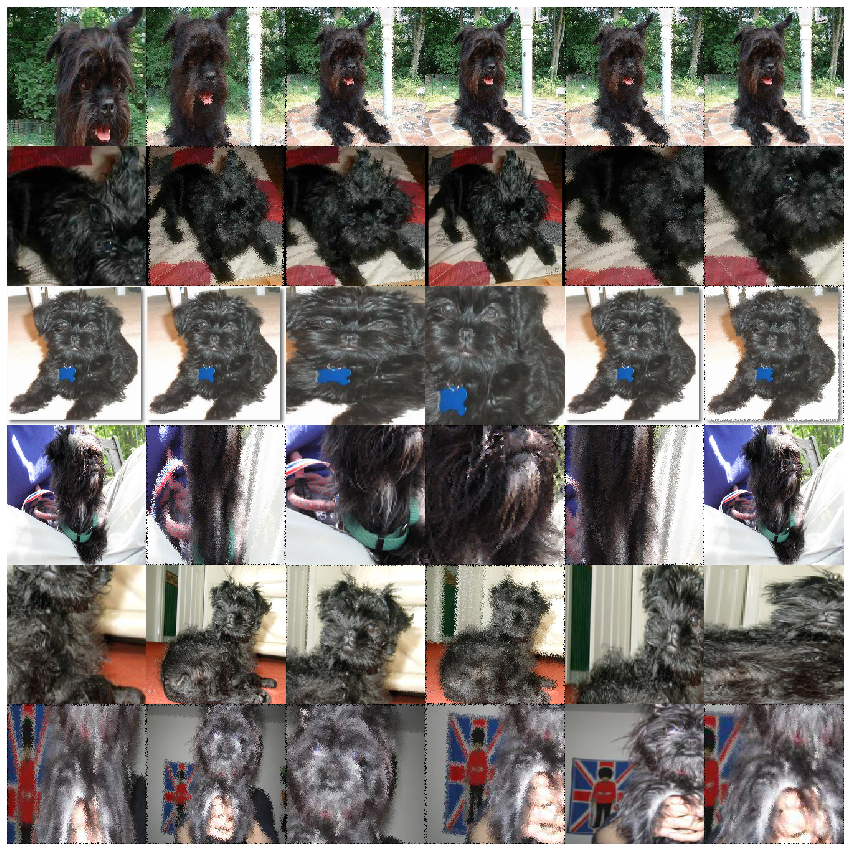

In [3]:
#!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia
import PIL
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(n)))
  plt.imshow(img)
  plt.axis('off')
  
class ImgAugTransform:
  def __init__(self):
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    self.aug = iaa.Sequential([
        iaa.Resize((224, 224)),
        #iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        #iaa.OneOf([iaa.GaussianBlur((0, 3.0)),iaa.AverageBlur(k=(2, 7)),iaa.MedianBlur(k=(3, 11)),]),
        #sometimes(iaa.Superpixels(p_replace=(0, 1.0),n_segments=(20, 200))),
        #iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
        #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
        #sometimes(iaa.OneOf([iaa.EdgeDetect(
        #          alpha=(0, 0.7)),iaa.DirectedEdgeDetect(
        #          alpha=(0, 0.7), direction=(0.0, 1.0)),])),
        #iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        #iaa.Fliplr(0.5),
        sometimes(iaa.Crop(percent=(0, 0.45))),
        #iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        #iaa.Invert(0.05, per_channel=True),
        #iaa.Add((-10, 10), per_channel=0.5),
        #iaa.Multiply((0.5, 1.5), per_channel=0.5),
        #iaa.LinearContrast((0.5, 2.0), per_channel=0.5),
        #iaa.Grayscale(alpha=(0.0, 1.0)),
        sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),
        #iaa.Sometimes(0.25,iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
        #                              iaa.CoarseDropout(0.1, 
        #                              size_percent=0.5)])),
        #iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
        #sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

transforms = ImgAugTransform()

dataset = torchvision.datasets.ImageFolder('/content/dog_images/train', transform=transforms)

show_dataset(dataset, 6)

In [0]:
import numpy as np
import time



def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, verbose=False):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    
    valid_loss_min = np.Inf 
    initial_time = time.time()
    train_losses, valid_losses = [], []
    
    for epoch in range(1, n_epochs+1):

        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        initial_epoch_time = time.time()
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            optimizer.zero_grad()
            log_ps = model(data)
            loss = criterion(log_ps, target)
            loss.backward()
            optimizer.step()
        
            #running_loss += train_loss.item()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #A
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss

                ps_log = model(data)
                loss = criterion(ps_log, target)
                valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)


                
            if verbose:
                final_epoch_time = time.time()
                print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime spent: {:.6f}'.format(
                   epoch, 
                   train_loss,
                   valid_loss,
                   final_epoch_time - initial_epoch_time
                   ))            
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
           #print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
           torch.save(model.state_dict(), save_path)
           valid_loss_min = valid_loss    
    # return trained model
    
    final_time = time.time()
    return model, train_losses, valid_losses, final_time - initial_time



ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

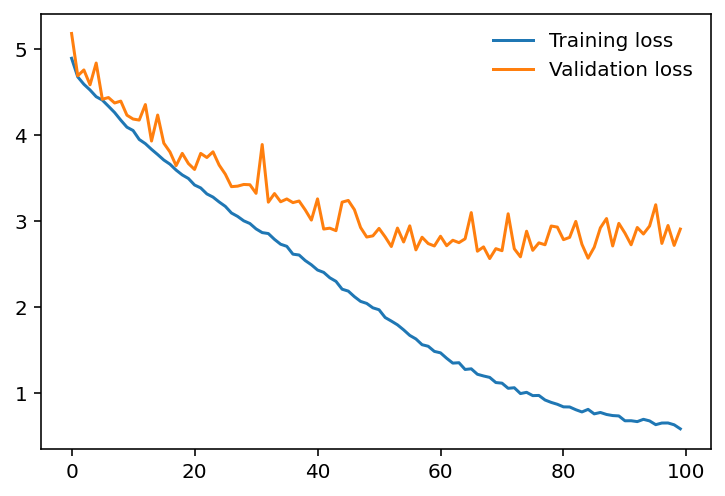

Test Loss: 2.454370

Test Accuracy: 40% (338/836)




In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import ImageFile
import matplotlib.pyplot as plt
import datetime
import torch.nn as nn
import torch.nn.functional as F
ImageFile.LOAD_TRUNCATED_IMAGES = True


mixed_transforms = torchvision.transforms.Compose([
    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([transforms.Resize(size=224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])



train_data = datasets.ImageFolder('dog_images/train', transform=mixed_transforms)
valid_data = datasets.ImageFolder('dog_images/valid', transform=valid_transforms)
test_data = datasets.ImageFolder('dog_images/test', transform=valid_transforms)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

loaders_scratch = {'train' : trainloader, 'valid' : validloader, 'test' : testloader}


class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block 
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )
        
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )
        
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))
    
class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=133):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the 
        same as a neuron netowork layer, ex. conv layer), one layer may 
        contain more than one residual block 
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block 
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        
        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output 

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])



model_scratch = resnet18()
print (model_scratch)

use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()

learning_rates = [
                 #0.001
                 0.0015,
                 #0.0025,
                 #0.0035

                 ]

optimizers = [
                #optim.Adagrad,
                optim.Adam
            ]


def test(loaders, model, criterion, use_cuda):
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    print('Test Loss: {:.6f}'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)\n\n' % (
        100. * correct / total, correct, total))

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)



def reboot(loaders, model, criterion):
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
      print('and then re-execute this cell.')
    else:
      print(gpu_info)    

    del loaders
    del model
    del criterion
    torch.cuda.empty_cache()
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
    validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True, num_workers=4)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)
    
    new_model = resnet18()
    new_model.apply(weights_init)
    new_model.cuda()
    
    new_criterion = criterion_scratch = nn.CrossEntropyLoss()
    
    return {'train' : trainloader, 'valid' : validloader, 'test' : testloader}, new_model, new_criterion

current_optimizer = ''
model_scratch = resnet18()
criterion_scratch = ''
for optimizer in optimizers:
    for lr in learning_rates:
        loaders_scratch, model_scratch, criterion_scratch = reboot(loaders_scratch, model_scratch, criterion_scratch)
        del current_optimizer
        current_optimizer = optimizer(model_scratch.parameters(), lr)
        
        print(current_optimizer)
        model, train_losses, valid_losses, time_spent = train(100, loaders_scratch, 
                                                              model_scratch, 
                                                              current_optimizer, 
                                                              criterion_scratch, 
                                                              use_cuda, 
                                                              'model_scratch.pt',
                                                              verbose=True)
        
        print("time spent: ", str(datetime.timedelta(seconds=time_spent)))
        
        min_train_loss = float(min(train_losses))
        min_valid_loss = float(min(valid_losses))
        
        print("Minimum trainig loss: ", min_train_loss)
        print("Minimum validation loss: ", min_valid_loss)

        plt.plot(train_losses, label='Training loss')
        plt.plot(valid_losses, label='Validation loss')
        
        plt.legend(frameon=False)
        plt.show()
       
        model_scratch.load_state_dict(torch.load('model_scratch.pt'))
        test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)
        
